In [71]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Load all prediction files

In [74]:
mid_price_pred = pd.read_csv('Predicted Mid-Price (Month).csv')
bid_ask_spred_pred = pd.read_csv('Predicted Bid-Ask Spread (Month).csv') 
order_imbalance_pred = pd.read_csv('Predicted Order Imbalance (Month).csv')

arima1_pred = pd.DataFrame()
arima1_pred['Time'] = mid_price_pred['Time'] 
arima1_pred['Mid-Price Actual'] = mid_price_pred['Actual']
arima1_pred['Mid-Price Predicted'] = mid_price_pred['Predicted']
arima1_pred['Bid-Ask Spread Actual'] = bid_ask_spred_pred['Actual']
arima1_pred['Bid-Ask Spread Predicted'] = bid_ask_spred_pred['Predicted']
arima1_pred['Order Imbalance Actual'] = order_imbalance_pred['Actual']
arima1_pred['Order Imbalance Predicted'] = order_imbalance_pred['Predicted']


# Convert the 'Time' column to datetime
arima1_pred['Time'] = pd.to_datetime(arima1_pred['Time'], format='%H:%M:%S')

#print(arima1_pred.head())
#print(arima1_pred.tail())
print(arima1_pred.index)

arima1_pred.to_csv('Predicted and Actual for 03.02.2025 ARIMA1.csv')


KeyError: 'Time'

Run Simulation

In [52]:
arima1_pred['DateTime'] = pd.to_datetime(arima1_pred.iloc[:, 0], format='%H:%M:%S')
arima1_pred.set_index('DateTime', inplace=True)

# Market impact and slippage values
market_impact_constant = 0.1 # Y in the price impact formula, chosen for illustrative purposes
average_daily_volume = arima1_pred['Mid-Price Actual'].count() # Simplified as count of rows for simulation purposes
brokerage_fee_bps = 0.50 / 100 # Brokerage fee in basis points
exchange_fee_per_share = 0.000025 # Exchange fee per share traded
shares_per_transaction = 100 # Assuming a fixed number of shares per transaction for simplicity

# Initial conditions for the simulation
initial_cash = 10000 # Starting cash
cash = initial_cash 
shares_owned = 0  # Starting shares owned
transactions = [] # List to record transactions

# Thresholds for market liquidity (placeholders, adjust based on data analysis if needed)
bid_ask_spread_threshold = arima1_pred['Bid-Ask Spread Actual'].quantile(0.5) # Median as threshold
order_imbalance_threshold = 0.10 # Placeholder, adjust based on data analysis

# Run the simulation
for i in range(len(arima1_pred)):
    actual_mid_price = arima1_pred.iloc[i]['Mid-Price Actual']
    predicted_mid_price = arima1_pred.iloc[i]['Mid-Price Predicted']
    bid_ask_spread = arima1_pred.iloc[i]['Bid-Ask Spread Actual']
    order_imbalance = arima1_pred.iloc[i]['Order Imbalance Actual']
    
    is_liquid = bid_ask_spread <= bid_ask_spread_threshold and abs(order_imbalance) <= order_imbalance_threshold
    
    # Buy condition: actual mid-price below predicted, and market is liquid
    if actual_mid_price < predicted_mid_price and is_liquid:
        shares_to_buy = min(shares_per_transaction, int(cash / (actual_mid_price + brokerage_fee_bps * actual_mid_price + exchange_fee_per_share)))
        if shares_to_buy > 0:
            volume_ratio = shares_to_buy / average_daily_volume
            price_impact = market_impact_constant * (volume_ratio ** 0.5) * actual_mid_price
            adjusted_buy_price = actual_mid_price + price_impact
            total_cost = adjusted_buy_price * shares_to_buy + brokerage_fee_bps * adjusted_buy_price * shares_to_buy + exchange_fee_per_share * shares_to_buy
            cash -= total_cost
            shares_owned += shares_to_buy
            transactions.append(('Buy', shares_to_buy, adjusted_buy_price, total_cost, cash, arima1_pred.index[i]))
    
    # Sell condition: actual mid-price above predicted, and market is liquid
    elif actual_mid_price > predicted_mid_price and is_liquid and shares_owned > 0:
        volume_ratio = shares_owned / average_daily_volume
        price_impact = market_impact_constant * (volume_ratio ** 0.5) * actual_mid_price
        adjusted_sell_price = actual_mid_price - price_impact
        total_revenue = adjusted_sell_price * shares_owned - brokerage_fee_bps * adjusted_sell_price * shares_owned - exchange_fee_per_share * shares_owned
        cash += total_revenue
        transactions.append(('Sell', shares_owned, adjusted_sell_price, total_revenue, cash, arima1_pred.index[i]))
        shares_owned = 0

# Final valuation
final_valuation = cash + shares_owned * arima1_pred.iloc[-1]['Mid-Price Actual']

# Output
initial_cash, final_valuation, final_valuation - initial_cash, len(transactions), transactions[:5]
print(f'Initial Cash: {initial_cash:.1f}')
print(f'Final Valuation: {final_valuation:.1f}')
print(f'Overall Profit/Loss: {final_valuation - initial_cash:.1f}')

Initial Cash: 10000
Final Valuation: 27765.91039169275
Overall Profit/Loss: 17765.91039169275


Make a plot of transactions

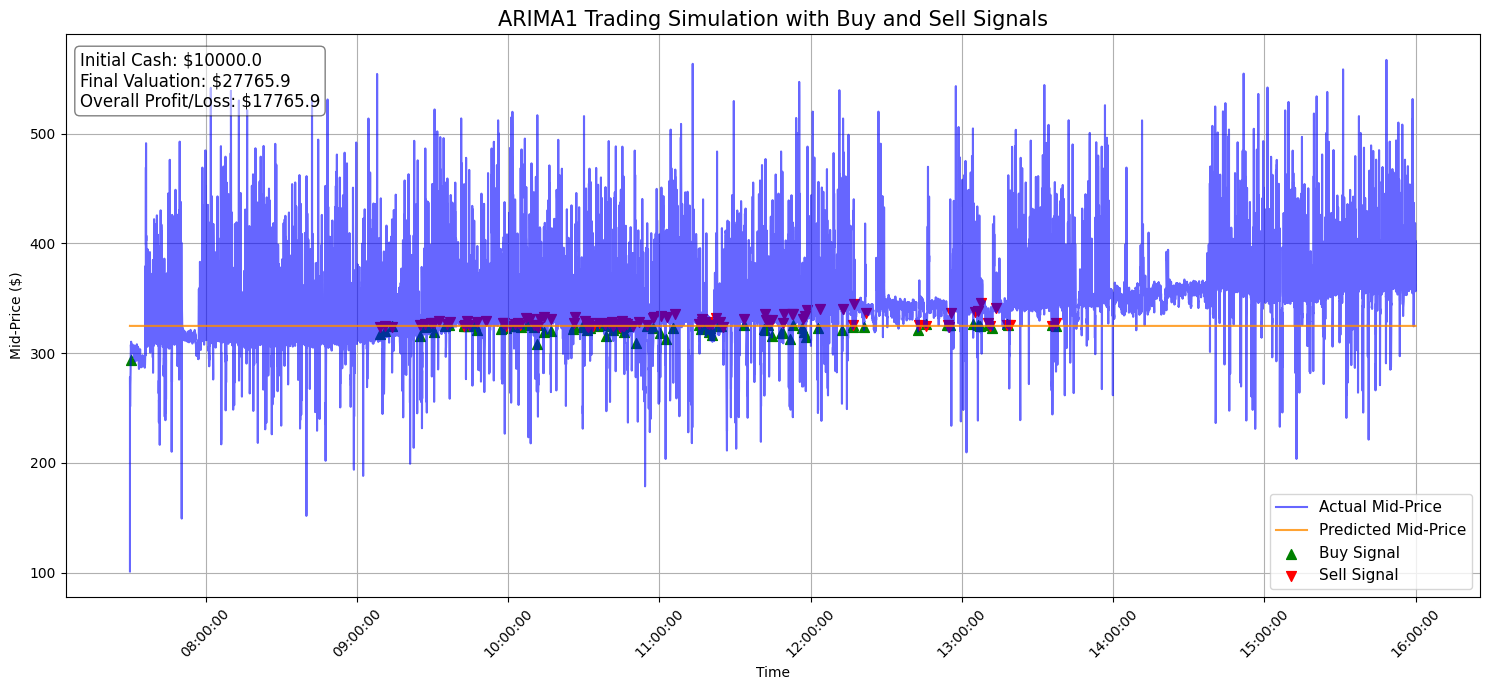

In [68]:
# Convert transactions to DataFrame
transactions_df = pd.DataFrame(transactions, columns=['Action', 'Shares', 'Price', 'Total Cost', 'Cash After', 'Time'])
transactions_df['DateTime'] = pd.to_datetime(transactions_df['Time'], format='%H:%M:%S').dt.time

# Plot
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(arima1_pred['Time'], arima1_pred['Mid-Price Actual'], label='Actual Mid-Price', color='blue', alpha=0.6)
ax.plot(arima1_pred['Time'], arima1_pred['Mid-Price Predicted'], label='Predicted Mid-Price', color='darkorange', alpha=0.8)

# Buy and sell
buy_signals = transactions_df[transactions_df['Action'] == 'Buy']
sell_signals = transactions_df[transactions_df['Action'] == 'Sell']
ax.scatter(buy_signals['Time'], buy_signals['Price'], label='Buy Signal', color='green', marker='^', s=50, alpha=1.0)
ax.scatter(sell_signals['Time'], sell_signals['Price'], label='Sell Signal', color='red', marker='v', s=50, alpha=1.0)

# Sort out xaxis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Add labels with model results
text_str = f'Initial Cash: ${initial_cash:.1f}\nFinal Valuation: ${final_valuation:.1f}\nOverall Profit/Loss: ${final_valuation - initial_cash:.1f}'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# Position the text on the axes (you may need to adjust the x and y values based on your plot's layout)
ax.text(0.01, 0.97, text_str, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_title('ARIMA1 Trading Simulation with Buy and Sell Signals', fontsize=15)
ax.set_xlabel('Time')
ax.set_ylabel('Mid-Price ($)')
ax.legend(fontsize=11)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

Export the figure

In [70]:
fig.savefig('Trading Simulation ARIMA1 Results.png', dpi=600, bbox_inches='tight')